# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

> Batch Normalization (BN), proposed by Sergey Ioffe and Christian Szegedy, is a technique designed to reduce vanishing and exploding gradient problems in deep neural networks. https://arxiv.org/abs/1502.03167

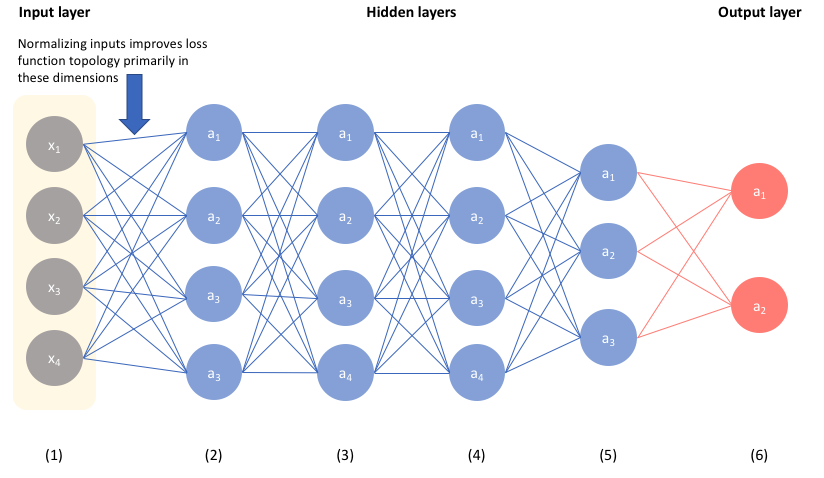

Read the link:

https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/

**What problem is BN fixing?**

As data passes through many layers, each layer changes the scale and distribution of the data.
So the next layer keeps receiving inputs that are:

- too large → exploding gradients

- too small → vanishing gradients

This makes training unstable and slow.

Scenario

> *Imagine you are learning with notes that keep changing format every day — sometimes the text is tiny, sometimes huge, sometimes centered, sometimes shifted to the side. Learning would be slow and confusing, right?*

Batch Normalization acts like a smart auto-adjuster inside the network:

- Looks at one mini-batch

  1. “What’s the average value?”

  2. “How spread out are the values?”

- Normalizes the data

  - Shifts inputs so they are centered around 0

  - Scales them so they have similar spread

  - Gives control back to the model

- Adds two learnable parameters in each layer:

  1. γ (scale) → how big values should be

  2. β (shift) → where the center should be

So the network is not forced to use zero-mean, unit-variance if that’s not optimal

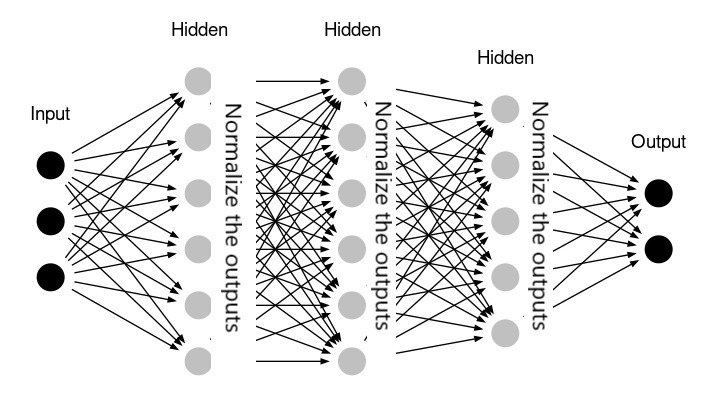

- For this reasons, when BN is the first layer, it already centers the inputs and normalizes their scale,

- So manual standardization (like StandardScaler) often becomes unnecessary.

### Steps of Batch Normalization

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of each input over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized in

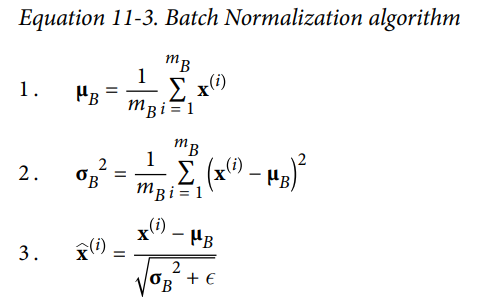

First, calculate (1) taverage and (2) the variance.
- μᴮ tells us where the center of the data is for this batch.
- σᴮ² tells us how big or small the values are in this batch.

Step (3) is to normalize the input >>> x(i)
- Subtract the mean → zero-centering
- Divide by standard deviation → scaling

Mean ≈ 0, Variance ≈ 1 ---- Standardization

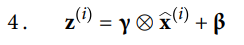

Step 4: Scale and shift (learnable part)

If we stop at normalization, the network is too constrained.

So BN adds:

- γ (gamma) → controls how much to scale

- β (beta) → controls where to shift

Both are learned during training.

> This helps to keep normalized inputs if useful or undo normalization if needed

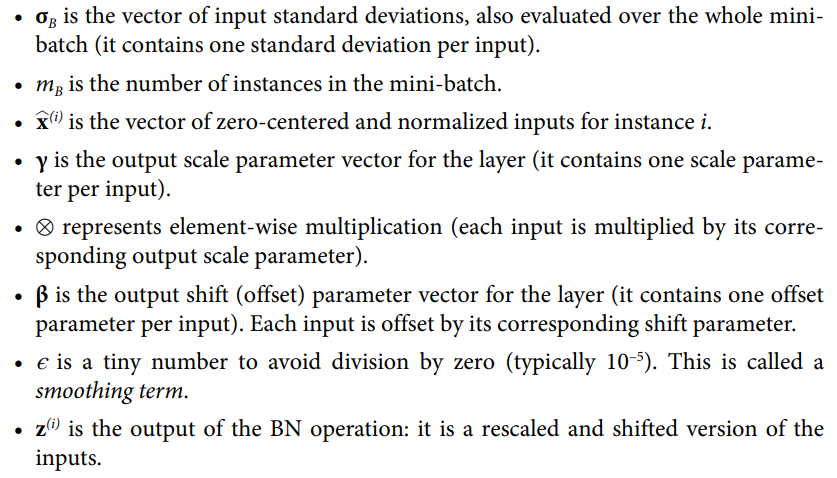

> Batch Normalization standardizes each input using mini-batch statistics,

> then lets the network decide the best scale and mean to use.

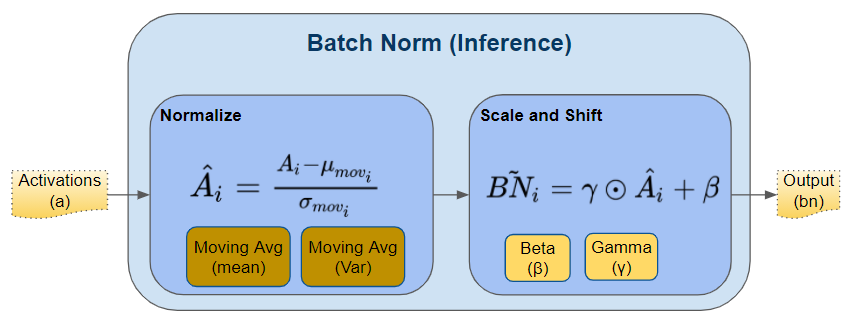

---

# Implementing Batch Normalization with Keras

As with most things with Keras, implementing Batch Normalization is quite simple. Just add a BatchNormalization layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model.

For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

### BN layers after the activation functions

In [1]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

You can see that each BN layer adds 4 parameters per input: γ, β, μ and σ
- for example, the first BN layer adds 3136 parameters, which is 4 times 784.

The last two parameters, μ and σ, are the moving averages, they are not affected by backpropagation, so Keras calls them “Nontrainable”.

In [3]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

### BN layers before the activation functions

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did).

---

There is some debate about this, as it seems to depend on the task. So that’s one more thing you can experiment with to see which option works best on your dataset. To add the BN layers before the activation functions, we must remove the activation function from the hidden layers, and add them as separate layers after the BN layers.

---

 Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it)

 ---

In [14]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
 keras.layers.BatchNormalization(),
 keras.layers.Activation("elu"),
 keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
 keras.layers.Activation("elu"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(10, activation="softmax")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,946 (1.03 MB)

 Trainable params: 268,578 (1.02 MB)

 Non-trainable params: 2,368 (9.25 KB)

## Paramters to tweak in BN

The BatchNormalization class has quite a few hyperparameters you can tweak.

But you may occasionally need to tweak the **`momentum`**.

This hyperparameter is used when updating the exponential moving averages: given a new value v.

>  v is a new vector of input means or standard deviations computed over
the current batch, the running average v hat is updated using the following equation.

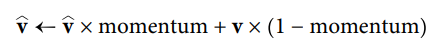

Another important hyperparameter is **`axis`**: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes)

---